# Analysis of StackOverflow Survey. Part III

In [81]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

from sklearn.linear_model import LinearRegression

from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import (
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

In [82]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

## How do the salaries of data coders compare with the salaries of the other coders?

This analysis is created after the Medium post [ANOVA Test, with Python](https://towardsdatascience.com/anova-test-with-python-cfbf4013328b). 

We are addressing the second question in this notebook. How do the salaries of data coders compare with the salaries of the other coders? In particular, we shall determine if there is a statistically significant difference between the average converted compensation of data coders versus the other coders.

First, we will conduct a paired one-tailed t-test for dependent means to compare the averages of the converted compensation, using the entries from the column 'imputedComp' obtained after imputing the missing values in 'ConvertedComp'. We will test the null hypothesis 
$$H_0: \mu_c - \mu_o  > 0$$
that the mean converted compensations of the data coders ($\mu_c$) are larger than for the other coders ($\mu_o$), against the 
$$H_a: \mu_c - \mu_o  \leq 0.$$

The test statistic used is $\delta = \mu_c - \mu_o$. I will work with a $10 \%$ significance level so that $\alpha = 0.01$.

Second, we compute the observed difference for the given sample. In order to decide if this difference is statistically significant or just due to chance we also perform and A/B test on a simulated sampling distribution.  

### Upload the processed data

In [83]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv')
dfs = pd.read_csv(mypath+'/data/survey20_results_schema.csv')

In [84]:
# check the uploaded data
df1.shape

(60430, 33)

### Descriptive statistics of the data

In [85]:
# create a dataframe with the variables of interest only
df2 = pd.DataFrame([df1.imputedComp, df1.DevClass]).transpose()
df2.head()

,imputedComp,DevClass
0,62697,other_coder
1,67215,other_coder
2,15900,other_coder
3,115000,other_coder
4,62697,other_coder


In [86]:
# check the attributes of the dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60430 entries, 0 to 60429
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   imputedComp  60430 non-null  object
 1   DevClass     60430 non-null  object
dtypes: object(2)
memory usage: 944.3+ KB


In [87]:
# change the Dtype of the imputedComp column
df2['imputedComp'] = pd.to_numeric(df2["imputedComp"])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60430 entries, 0 to 60429
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   imputedComp  60430 non-null  float64
 1   DevClass     60430 non-null  object 
dtypes: float64(1), object(1)
memory usage: 944.3+ KB


In [89]:
# determine how many entries have 0 compensation
df2[df2.imputedComp == 0.0].shape

(190, 2)

In [90]:
# drop those values with 0 imputedCompensation
df2.drop(df2[df2.imputedComp == 0.0].index, inplace = True)

In [91]:
# check for success
df2[df2.imputedComp == 0.0].shape

(0, 2)

In [92]:
# the records for the other coders
df2_other = df2[df2.DevClass == 'other_coder']
df2_other.shape

(51566, 2)

In [93]:
# the records for the data coders
df2_data = df2[df2.DevClass == 'data_coder']
df2_data.shape

(8674, 2)

<AxesSubplot:xlabel='imputedComp', ylabel='Count'>

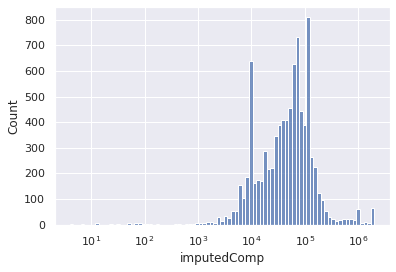

In [94]:

sns.histplot(data = df2_data, x = df2_data.imputedComp, log_scale=True)
#df2_data.imputedComp.astype(float)

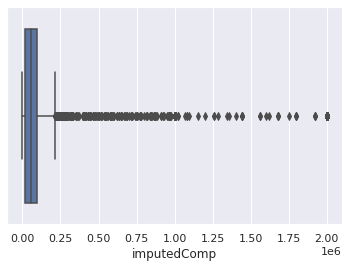

In [95]:
sns.boxplot(data=df2_data, x='imputedComp');

<AxesSubplot:xlabel='imputedComp', ylabel='Count'>

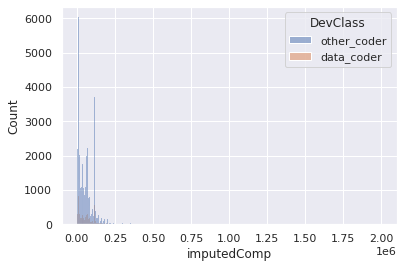

In [28]:
sns.histplot(data=df2, x='imputedComp', hue='DevClass')